In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* List of items in the bin

In [3]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [3]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [4]:
contents = [s.lower() for s in contents]

## Phase 1: Recognition by SIFT Features
### Compute Features in Bin

1067 features detected


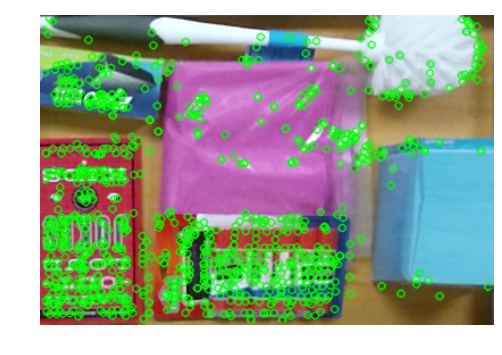

In [5]:
from utils import imread_rgb, compute_sift

filename_bin = 'bin/' + bin_stamp + '.png'
image_bin = imread_rgb(filename_bin)
(kp_bin, des_bin) = compute_sift(image_bin)

### Match Bin and Items Features

Item: "Training_items/glue_sticks/glue_sticks_top_01_sift.npy" Good features: 5
Item: "Training_items/tissue_box/tissue_box_top_01_sift.npy" Good features: 3
Item: "Training_items/laugh_out_loud_jokes/laugh_out_loud_jokes_top_01_sift.npy" Good features: 12
Item: "Training_items/toilet_brush/toilet_brush_top_01_sift.npy" Good features: 2
Item: "Training_items/expo_eraser/expo_eraser_top_01_sift.npy" Good features: 26
Item: "Training_items/table_cloth/table_cloth_top_01_sift.npy" Good features: 3


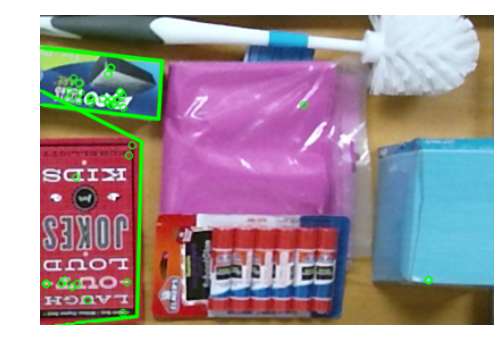

In [6]:
from utils import match_items

items = list(contents)
item_d, recognised_items, mask_items = match_items(image_bin, kp_bin, des_bin, items)

### Not recognised items

In [7]:
items = [s for s in contents if s not in recognised_items]
items

['glue_sticks', 'tissue_box', 'toilet_brush', 'table_cloth']

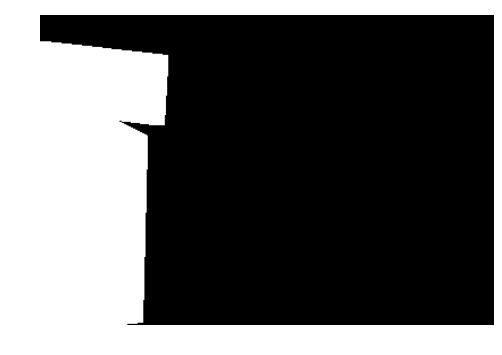

In [8]:
kernel = np.ones((3,3),np.uint8)
mask_items = cv2.dilate(mask_items,kernel,iterations = 5)
plt.imshow(mask_items,cmap='gray'), plt.axis('off');

## Phase 2: segment bin by depth into upper / lower levels

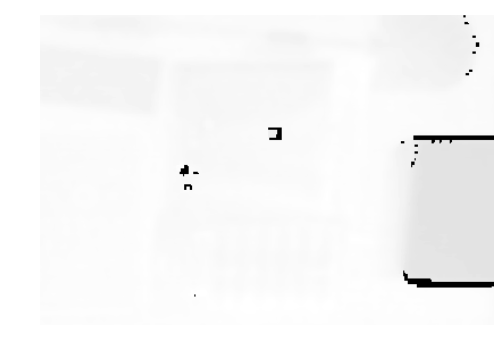

In [9]:
from utils import imread_gray
filename_bin = 'bin/' + bin_stamp + '.pgm'
image_depth = imread_gray(filename_bin)
plt.imshow(image_depth,cmap='gray'); plt.axis('off');

(227, 255)

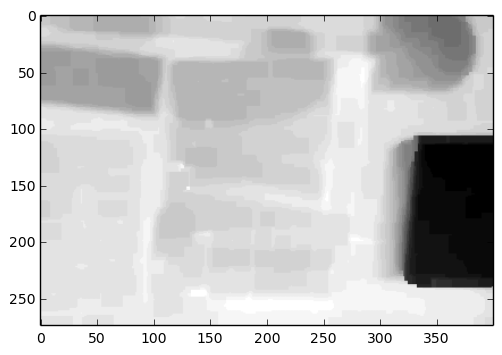

In [27]:
from utils import fill_holes

image_depth = fill_holes(image_depth)
plt.imshow(image_depth,cmap='gray');
(np.min(image_depth), np.max(image_depth))

In [21]:
min_depth = int(np.min(image_depth))
thresh_depth = min_depth + 1
stop = False
while not stop:
    top_obj = cv2.inRange(image_depth,min_depth,thresh_depth)
    top_obj = cv2.bitwise_and(top_obj, top_obj, mask=255-mask_items)
    (cnt,_) = cv2.findContours(top_obj,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt)>0:
        #max_cnt = max(cnt, key = cv2.contourArea)
        #stop = (cv2.contourArea(max_cnt) > 10000)
        cnt = sorted(cnt, key = cv2.contourArea, reverse=True)
        stop = (cv2.contourArea(cnt[0]) > 10000)
    thresh_depth += 1
max_cnt = cnt[0]

In [22]:
item_mask = np.zeros(top_obj.shape,dtype='uint8')
cv2.drawContours(item_mask,[max_cnt],-1,(255,),-1)
image_top = cv2.bitwise_and(image_bin,image_bin,mask=item_mask)

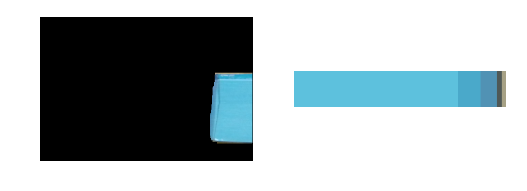

In [23]:
from utils import compute_colors, plot_colors

h_obj, cc_obj = compute_colors(image_bin, item_mask)
plt.subplot(121); plt.imshow(image_top); plt.axis('off');
bar = plot_colors(h_obj, cc_obj)
plt.subplot(122); plt.imshow(bar); plt.axis('off');

In [24]:
import glob
import json
dc_list = []
for item in items:
    folder = 'Training_items/' + item + '/'
    files = glob.glob(folder + '*_dc.json')
    for filename in files:
        with open(filename) as data_file:
            dominant_colors = json.load(data_file)
        dc_list.append((filename,dominant_colors))

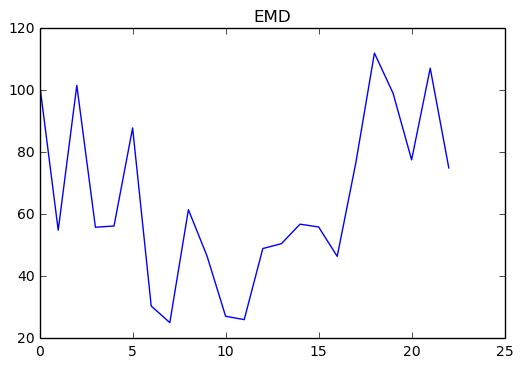

25.11 tissue_box/tissue_box_bottom-side_01
26.07 tissue_box/tissue_box_bottom-side_02
27.15 tissue_box/tissue_box_top-side_01
30.46 tissue_box/tissue_box_top-side_02
46.48 toilet_brush/toilet_brush_bottom_01
46.60 tissue_box/tissue_box_bottom_01
49.00 toilet_brush/toilet_brush_bottom-side_01
50.58 toilet_brush/toilet_brush_top_01
54.91 glue_sticks/glue_sticks_bottom_01
55.87 glue_sticks/glue_sticks_bottom-side_01


In [25]:
from utils import calc_EMD2

ddc = []
refdc = []
for name, dc in dc_list:
    h_ref = dc['hist']
    cc_ref = dc['cluster_centers']
    emd = calc_EMD2(h_obj,cc_obj,h_ref,cc_ref)
    refdc.append(name)
    ddc.append(emd)
plt.plot(ddc), plt.title('EMD'), plt.show();
ddc, refdc = zip(*sorted(zip(ddc, refdc)))
for idx in range(10):
    print('%.2f %s' % (ddc[idx], refdc[idx][15:-8]))

In [19]:
len(cnt)

2

In [20]:
min_depth

227

In [54]:
# for all thresh_depth in [min_depth+1, max_depth]
# compute mask and contours
#   for each contour and item/view
#     compute EMD
# sort results by EMD
# get first result for each item